# SNOwGLoBES Tarfile Reader

Use the `tarfile` module to loop through the SNOwGLoBES files in a directory and push the data into an astropy table.

In [1]:
import tarfile
import numpy as np
from astropy.table import Table
import astropy.units as u

import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

from scipy.special import loggamma

mpl.rc('font', size=14)

## Open Tarfile

In [2]:
# tf = tarfile.open('../../Type Ia/DDT_NeutrinoFlux.tar.bz2')
tf = tarfile.open('../../PISN/PISN_150Msun_EOS=Helm_NeutrinoFlux.tar.bz2')

### Read File List

Grab the list of files inside the archive using a list comprehension.

In [3]:
datafiles = sorted([f.name for f in tf if '.dat' in f.name])
datafiles

['72TimeBins/NuFluxPISN150_TBin10_IH.dat',
 '72TimeBins/NuFluxPISN150_TBin10_NH.dat',
 '72TimeBins/NuFluxPISN150_TBin10_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin11_IH.dat',
 '72TimeBins/NuFluxPISN150_TBin11_NH.dat',
 '72TimeBins/NuFluxPISN150_TBin11_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin12_IH.dat',
 '72TimeBins/NuFluxPISN150_TBin12_NH.dat',
 '72TimeBins/NuFluxPISN150_TBin12_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin13_IH.dat',
 '72TimeBins/NuFluxPISN150_TBin13_NH.dat',
 '72TimeBins/NuFluxPISN150_TBin13_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin14_IH.dat',
 '72TimeBins/NuFluxPISN150_TBin14_NH.dat',
 '72TimeBins/NuFluxPISN150_TBin14_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin15_IH.dat',
 '72TimeBins/NuFluxPISN150_TBin15_NH.dat',
 '72TimeBins/NuFluxPISN150_TBin15_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin16_IH.dat',
 '72TimeBins/NuFluxPISN150_TBin16_NH.dat',
 '72TimeBins/NuFluxPISN150_TBin16_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin17_IH.dat',
 '72TimeBins/NuFluxPISN150_TBin17

### No-oscillation Scenario

Extract the "NoOsc" files.

In [4]:
noosc = [df for df in datafiles if 'NoOsc' in df]
noosc.sort(key = len)
noosc

['72TimeBins/NuFluxPISN150_TBin1_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin2_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin3_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin4_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin5_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin6_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin7_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin8_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin9_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin10_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin11_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin12_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin13_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin14_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin15_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin16_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin17_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin18_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin19_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin20_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin21_NoOsc.dat',
 '72TimeBins/NuFluxPISN150_TBin22_NoOsc.dat

### Extract Data

Loop through the "NoOsc" files and extract data into `astropy.Table` objects.

In [5]:
time = []
energy = None
flux = {}

for nooscfile in noosc:
    with tf.extractfile(nooscfile) as f:
        meta = f.readline()
        metatext = meta.decode('utf-8')
        print(metatext)
        t = float(metatext.split('TBinMid=')[-1].split('sec')[0]) #* u.s
        dt = float(metatext.split('tBinWidth=')[-1].split('s')[0]) * u.s
        dE = float(metatext.split('eBinWidth=')[-1].split('MeV')[0]) * u.MeV
        
        data = Table.read(f, format='ascii.commented_header', header_start=-1)
        data.meta['t'] = t
        data.meta['dt'] = dt
        data.meta['dE'] = dE
        
        time.append(t)
        if energy is None:
            energy = (data['E(GeV)'].data*1000).tolist()

        for flavor in ['NuE', 'NuMu', 'NuTau', 'aNuE', 'aNuMu', 'aNuTau']:
            if flavor in flux:
                flux[flavor].append(data[flavor].data.tolist())
            else:
                flux[flavor] = [data[flavor].data.tolist()]

# Transpose so that table rows are energy and columns are time.
for k, v in flux.items():
    flux[k] = np.transpose(flux[k])

# PISN150@TBinMid=-22.95sec@(tBinWidth=0.5s)(eBinWidth=0.2MeV)	Flux in Number Neutrinos per cm^2					

# PISN150@TBinMid=-22.45sec@(tBinWidth=0.5s)(eBinWidth=0.2MeV)	Flux in Number Neutrinos per cm^2					

# PISN150@TBinMid=-21.95sec@(tBinWidth=0.5s)(eBinWidth=0.2MeV)	Flux in Number Neutrinos per cm^2					

# PISN150@TBinMid=-21.45sec@(tBinWidth=0.5s)(eBinWidth=0.2MeV)	Flux in Number Neutrinos per cm^2					

# PISN150@TBinMid=-20.95sec@(tBinWidth=0.5s)(eBinWidth=0.2MeV)	Flux in Number Neutrinos per cm^2					

# PISN150@TBinMid=-20.45sec@(tBinWidth=0.5s)(eBinWidth=0.2MeV)	Flux in Number Neutrinos per cm^2					

# PISN150@TBinMid=-19.95sec@(tBinWidth=0.5s)(eBinWidth=0.2MeV)	Flux in Number Neutrinos per cm^2					

# PISN150@TBinMid=-19.45sec@(tBinWidth=0.5s)(eBinWidth=0.2MeV)	Flux in Number Neutrinos per cm^2					

# PISN150@TBinMid=-18.95sec@(tBinWidth=0.5s)(eBinWidth=0.2MeV)	Flux in Number Neutrinos per cm^2					

# PISN150@TBinMid=-18.45sec@(tBinWidth=0.5s)(eBinWidth=0.2MeV)	Flux in Nu

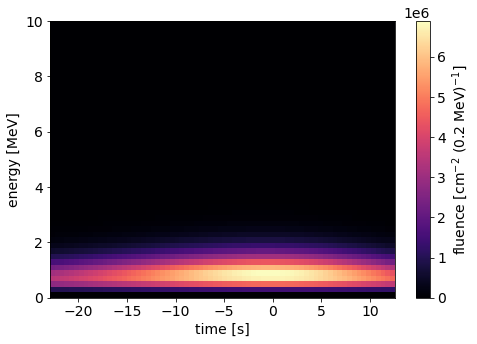

In [6]:
nt, nE = len(time), len(energy)

fig, ax = plt.subplots(1,1, figsize=(7,5))
im = ax.imshow(flux['NuE'], extent=[time[0], time[-1], energy[0], energy[-1]],
               origin='lower', cmap='magma',
               aspect='auto')
cb = fig.colorbar(im, ax=ax)
cb.set_label('fluence [cm$^{-2}$ (0.2 MeV)$^{-1}$]')
ax.set(xlim=(time[0], time[-1]), xlabel='time [s]',
       ylim=(0,10), ylabel='energy [MeV]')
fig.tight_layout()

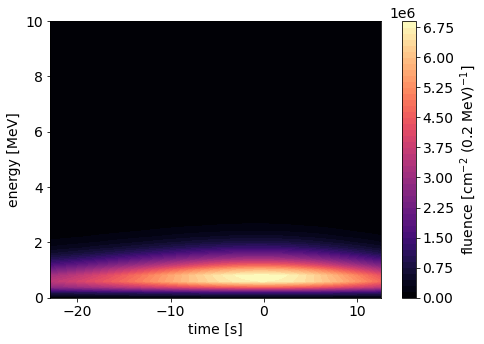

In [7]:
t_, E_ = np.meshgrid(time, energy)

fig, ax = plt.subplots(1,1, figsize=(7,5))
cf = ax.contourf(t_, E_, flux['NuE'], levels=50, cmap='magma')
cb = fig.colorbar(cf, ax=ax)
cb.set_label('fluence [cm$^{-2}$ (0.2 MeV)$^{-1}$]')
ax.set(xlim=(time[0], time[-1]), xlabel='time [s]',
       ylim=(0,10), ylabel='energy [MeV]')
fig.tight_layout()

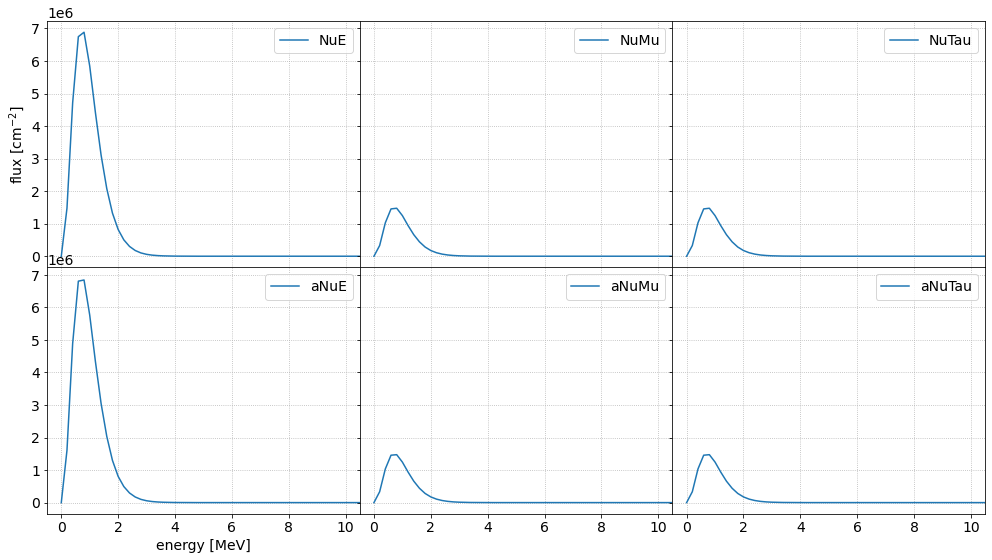

In [8]:
def get_closest(arr, x):
    return np.abs(np.asarray(arr) - x).argmin()

i = get_closest(time, 0.)

fig, axes = plt.subplots(2,3, figsize=(14,8), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for ax, (flavor, fl) in zip(axes.flatten(), flux.items()): 
    ax.plot(energy, fl[:,i], label=flavor)
    ax.legend()
    ax.grid(ls=':')
    
axes[0,0].set(ylabel='flux [cm$^{-2}$]')
axes[1,0].set(xlabel='energy [MeV]', xlim=(-0.5,10.5))
fig.tight_layout()

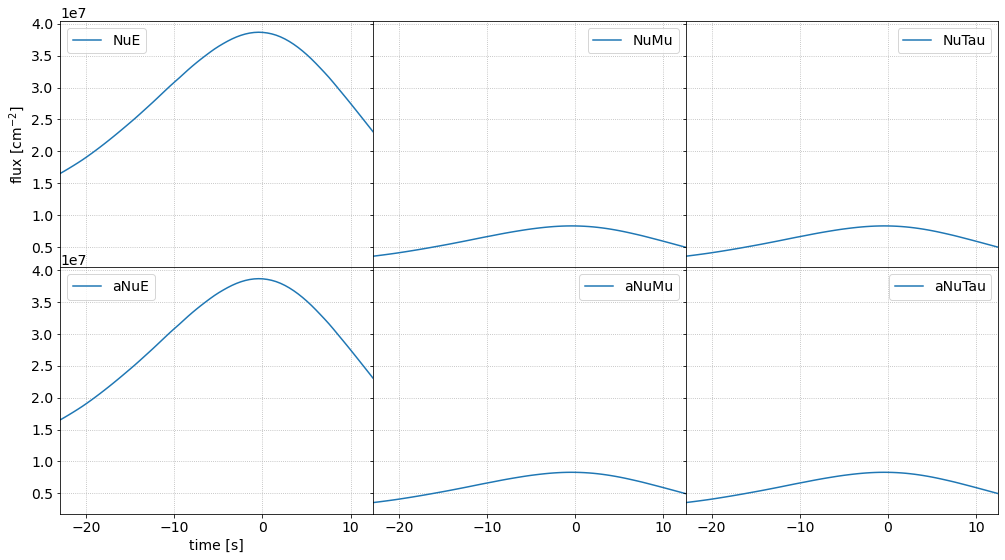

In [9]:
fig, axes = plt.subplots(2,3, figsize=(14,8), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for ax, (flavor, fl) in zip(axes.flatten(), flux.items()): 
    ax.plot(time, np.sum(fl, axis=0), label=flavor)
    ax.legend()
    ax.grid(ls=':')
    
axes[0,0].set(ylabel='flux [cm$^{-2}$]')
axes[1,0].set(xlabel='time [s]', xlim=(time[0], time[-1]))
fig.tight_layout()